In [9]:
from overcooked_ai_py.utils import load_pickle, mean_and_std_err
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# from human_ai_robustness.qualitative_robustness_expt import filter_tests_by_attribute, AbstractRobustnessTest
ALL_TEST_TYPES = ["state_robustness", "agent_robustness", "agent_robustness_plus_memory"] # AbstractRobustnessTest.ALL_TEST_TYPES

In [11]:
def set_style(font_scale=1.6, tex=True):
    import seaborn, matplotlib
    seaborn.set(font='serif', font_scale=font_scale)
    # Make the background white, and specify the specific font family
    seaborn.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})
    matplotlib.rcParams['text.usetex'] = tex
    matplotlib.rc('font',family='serif', serif=['Palatino'])
    
set_style(tex=False)

In [12]:
def filter_tests_by_attribute(tests_dict, attribute, value):
    """
    Returns tests that have `attribute` == `value`
    """
    filtered_tests = {}
    for test_name, test_data_dict in tests_dict.items():
        if test_data_dict[attribute] == value:
            filtered_tests[test_name] = test_data_dict
    return filtered_tests

def average_across_tests(tests_dict, avg_name):
    """
    Takes in a PER-LAYOUT data format dict and outputs a dict with
    average success rate (currenlty doesn't do ses).
    """
    averaged_test = defaultdict(dict)
    
    tests_layout = list(tests_dict.values())[0]['layout']
    assert all(test['layout'] == tests_layout for test in tests_dict.values())
    averaged_test_dict = {}
    # We want to see what the average test score for this type of test (e.g. agent_robustness) is
    # across seeds, and take the SE w.r.t. to that
    averaged_test_dict["success_rate_across_seeds"] = np.mean(
        [test["success_rate_across_seeds"] for test in tests_dict.values()], axis=0
    )
    averaged_test_dict["layout"] = tests_layout
    return averaged_test_dict

def average_across_different_test_types(tests_dict):
    """
    Takes in a PER-LAYOUT data format dict and outputs a PER-LAYOUT data
    format dict in which all the tests are replaced with the test types in
    ALL_TEST_TYPES, and the success rates are averaged across the different
    tests that compose them
    """
    new_tests_dict = defaultdict(lambda: defaultdict(dict))
    for agent_name, agent_data in tests_dict.items():
        for test_type in ALL_TEST_TYPES:
            filtered_tests_dict = filter_tests_by_attribute(agent_data, "test_types", [test_type])
            new_tests_dict[agent_name][test_type] = average_across_tests(filtered_tests_dict, test_type)
    return new_tests_dict

def filter_all_tests_by_attribute(all_test_data, attribute, value):
    return { agent_name : filter_tests_by_attribute(test_dict, attribute, value) for agent_name, test_dict in all_test_data.items() }

def simple_layout_histogram(results_dicts, barWidth=0.2):
    
    layout = list(list(results_dicts.values())[0].values())[0]['layout']
    
    success_means_by_agent = defaultdict(list)
    success_ses_by_agent = defaultdict(list)

    for agent_type, result_dict in results_dicts.items():
        for test_name, test_data in result_dict.items():
            assert layout == test_data["layout"], "All in same results sub-dict should be from the same layout"
            success_mean, success_se = mean_and_std_err(test_data["success_rate_across_seeds"])
            success_means_by_agent[agent_type].append(success_mean)
            success_ses_by_agent[agent_type].append(success_se)
    
    x_axis = [k for k, v in list(results_dicts.values())[0].items() if v['layout'] == layout]
    xs = list(range(len(x_axis)))
    
    plt.figure(figsize=(20,10))
    for k in results_dicts.keys():
        xs = np.array(xs) + barWidth
        ys = success_means_by_agent[k]
        yerrs = success_ses_by_agent[k]
        plt.bar(xs, ys, yerr=yerrs, width=barWidth, label=k, color=colors_fn(k))
    plt.title("qualitative experiments across models for layout {}".format(layout))
    plt.ylabel("success rate")
    plt.xticks([r + barWidth for r in range(len(xs))], x_axis)
    plt.grid()
    plt.legend()
    
def multi_plot_histograms(results_dicts, layouts, barWidth=0.2):
    # TODO
    pass

def colors_fn(agent_name):
    if agent_name == "agent_0":
        return "red"
    elif agent_name == "agent_1":
        return "blue"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

## Testing and example plots

In [13]:
# You load results for each agent that you've evaluated independently, and just have to specify the agent's name

results_a = load_pickle("sample_data")
results_b = load_pickle("sample_data")

results_a['Test1ci'] = {'layout': 'coordination_ring',
  'env_horizon': 15,
  'test_types': ['agent_robustness'],
  'num_rollouts_per_initial_state': 1,
  'trained_agent_type': 'ppo',
  'agent_run_name': 'lstm_agent_cring_1tom',
  'success_rate_across_seeds': [0.49, 0.23]
}
results_b['Test1ci'] = {'layout': 'coordination_ring',
  'env_horizon': 15,
  'test_types': ['agent_robustness'],
  'num_rollouts_per_initial_state': 1,
  'trained_agent_type': 'ppo',
  'agent_run_name': 'lstm_agent_cring_1tom',
  'success_rate_across_seeds': [0.23, 0.23]
}

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cring = {
    # Agent name    # Agent results dict as saved by script
    "agent_0":      results_a,
    "agent_1":      results_b
}

# ACROSS-LAYOUT data format
# Standard data format across-layout
results_bottleneck = None
results_across_layouts = {
    "bottleneck": results_bottleneck,
    "coordination_ring": results_cring
}

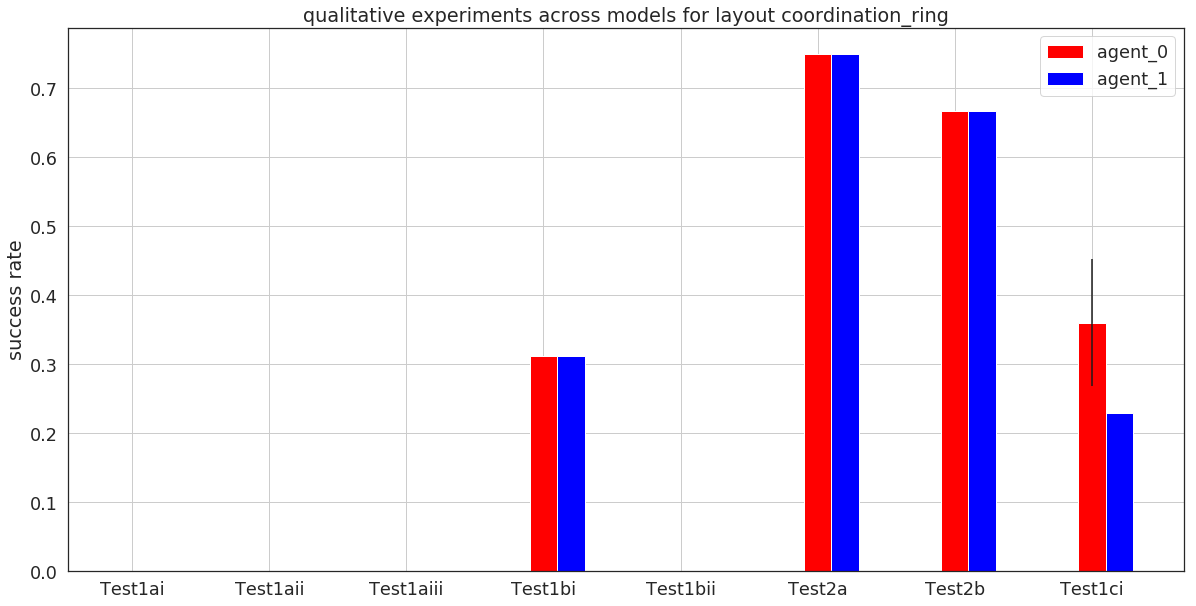

In [6]:
# Then you can plot a graph for each layout separately which compares the agents
simple_layout_histogram(results_cring)

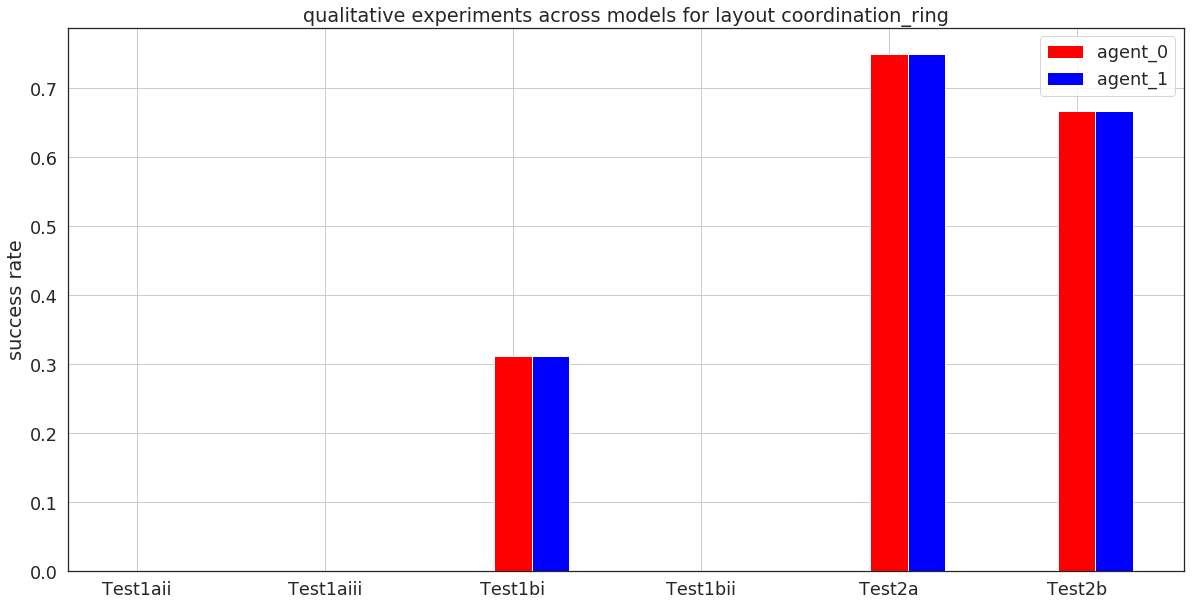

In [7]:
# You can do this after filtering for a certain test type, but still having the split by test
results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["state_robustness"])
simple_layout_histogram(results_filtered)

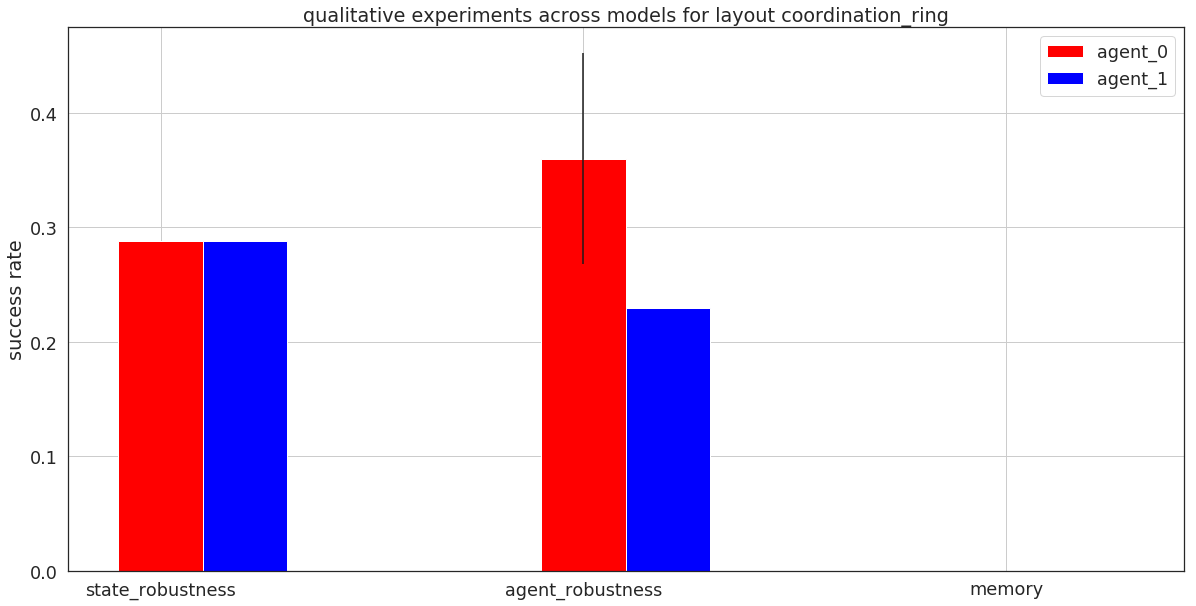

In [8]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cring)
simple_layout_histogram(averaged_by_test_type_results)

## Initial results for cring and cc